In [1]:
import pandas as pd
import os
import csv
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv('metadata.csv')

In [3]:
depths_list = [2.0, 5.0, 10.0, 15.0, 20.0]
study_sites = metadata[metadata['sensor_depth_at_low_tide_m'].isin(depths_list)][['waterbody', 'station', 'sensor_depth_at_low_tide_m']].drop_duplicates()
study_sites.reset_index(drop=True, inplace=True)

In [4]:


study_sites

,waterbody,station,sensor_depth_at_low_tide_m
0,Annapolis Basin,Cornwallis,2.0
1,Annapolis Basin,Lobster Ledge,2.0
2,Beaver Harbour,Beaver Point,5.0
3,Beaver Harbour,Beaver Point,2.0
4,Beaver Harbour,Beaver Point,10.0
...,...,...,...
317,Little Harbour,Red Point,10.0
318,Aspy Bay,North Harbour,5.0
319,Aspy Bay,North Harbour,2.0
320,Bras d'Or Lakes,Great Bras d'Or Channel NE-W,15.0


In [5]:
from tqdm.notebook import tqdm

In [18]:
first_date = None
last_date = None
start_date = "2015-07-29 00:00:00"
end_date = "2024-11-21 00:00:00"

daily_time_index = pd.date_range(start=start_date, end=end_date, freq='D')

study_site_data = []

for study_site_id  in tqdm(study_sites.index):

    data = pd.DataFrame(index=daily_time_index)

    study_site = study_sites.iloc[study_site_id]
    
    subset = metadata[ (metadata['waterbody'] == study_site.waterbody) &  (metadata['station'] == study_site.station) & (metadata['sensor_depth_at_low_tide_m'] == study_site.sensor_depth_at_low_tide_m)]

    series_segments = []
    for segment_id in subset.index:

        series_filename = os.path.join(variable, f'{segment_id}_{variable}.csv')
        series = pd.read_csv(series_filename, index_col='timestamp_utc', parse_dates=True, date_format="%m/%d/%Y %I:%M:%S %p")
        series.sort_index(inplace=True)

        # blank out observations that do not pass QC
        series[series[qcflag] != 'Pass'] = np.nan
        series = series.drop(columns=[qcflag])
       
        if series.count()[variable] > 0:
            series_segments.append(series)

    if len(series_segments) > 0:
        series_df = pd.concat(series_segments)
        series_df.sort_index(inplace=True)

        daily_series_df = series_df.resample('D').mean()
        if first_date is None or first_date > daily_series_df.index[0]:
            first_date = daily_series_df.index[0]
        if last_date is None or last_date < daily_series_df.index[-1]:
            last_date = daily_series_df.index[-1]
        
        data[study_site_id] = daily_series_df
    else:
        data[study_site_id] = np.nan

    study_site_data.append(data)



print(first_date)
print(last_date)
        

    

  0%|          | 0/322 [00:00<?, ?it/s]

2015-07-29 00:00:00
2024-11-21 00:00:00


In [30]:
df = pd.concat(study_site_data, axis=1)

In [31]:
df.to_csv('data.csv', index_label='date')

In [298]:
df = pd.read_csv('data.csv', parse_dates=True, index_col=0)

In [299]:
df

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
date,,,,,,,,,,,,,,,,,,,,,
2015-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
# Define the cutoff date
cutoff_date = "2020-06-01"

# Select rows past the cutoff date
df = df[df.index >=  pd.Timestamp(cutoff_date)]

# Define the cutoff date
cutoff_date = "2024-06-01"

df = df[df.index <  pd.Timestamp(cutoff_date)]

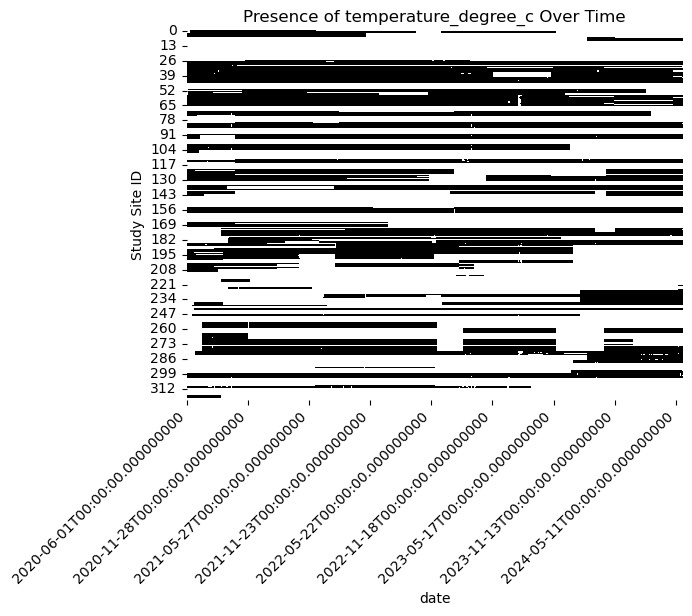

In [301]:
non_missing_data = ~df.isna()

import seaborn as sns
from matplotlib.dates import DateFormatter

plt.figure()
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

plt.ylabel('Study Site ID')
plt.title(f'Presence of {variable} Over Time')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

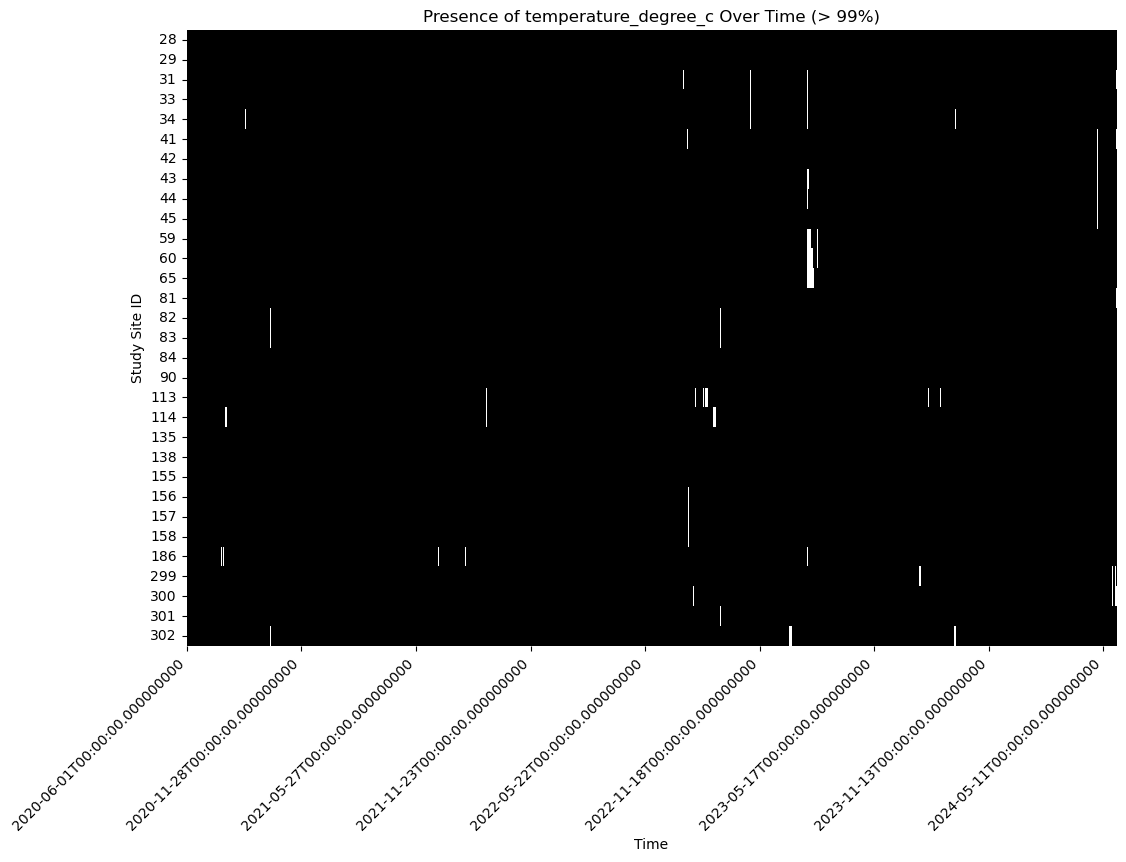

In [307]:
# Calculate the percentage of non-missing data for each study site
non_missing_percentage = df.notna().mean() * 100

# Filter study sites with at least 50% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >= 99].index
df_selected = df[selected_sites]

# Creating a boolean DataFrame where True indicates non-missing data
non_missing_data = ~df_selected.isna()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

# Formatting the time axis labels
date_format = DateFormatter('%Y-%m-%d %H:%M')
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Time')
plt.ylabel('Study Site ID')
plt.title(f'Presence of {variable} Over Time (> 99%)')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


In [308]:
df_selected

,28,29,31,33,34,41,42,43,44,45,...,138,155,156,157,158,186,299,300,301,302
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,4.197639,6.454596,9.529580,3.631400,3.334823,8.434240,7.626667,4.356500,4.877646,5.972792,...,2.487500,1.958292,5.307083,2.347458,1.012500,6.877900,2.988958,8.874461,2.352760,1.291667
2020-06-02,3.581806,5.852821,7.343972,3.261156,3.065167,9.896635,9.364653,4.248385,4.498625,6.275287,...,2.970833,2.291698,4.367802,2.809573,1.245833,5.413583,3.170903,5.931818,2.461698,1.270833
2020-06-03,4.045000,4.881542,6.933732,3.388055,2.934104,9.446708,7.714718,4.244375,4.436823,5.148438,...,3.091304,2.497295,4.391292,3.126968,1.400000,5.097958,3.833333,4.948095,3.133750,1.895833
2020-06-04,5.172639,5.589927,7.458958,3.351885,2.979823,9.173892,6.280909,4.172688,4.267812,4.903719,...,2.566667,2.490406,4.290031,3.332010,1.479167,6.008333,3.836806,4.457490,3.022958,1.729167
2020-06-05,5.240278,6.161083,7.451042,3.551417,3.040417,8.963098,6.332958,4.390354,4.542833,4.901135,...,2.636364,2.742906,4.728750,3.475552,1.562500,6.805167,5.238611,5.648625,3.456313,1.908333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,8.793194,10.010917,10.691952,7.108116,5.979292,11.173289,10.583883,6.222875,6.770813,8.610284,...,5.091667,4.830281,7.754177,5.506083,5.237500,7.194604,8.790305,8.918588,7.392490,4.279167
2024-05-28,10.259931,10.436146,10.275042,9.305885,7.047649,10.986306,10.485278,6.478833,7.280875,8.981417,...,6.358333,6.233146,8.267771,7.462948,5.695833,7.258167,8.976319,8.788448,8.567979,4.837500
2024-05-29,10.079167,10.424000,9.701333,8.835250,8.168365,10.996816,9.958056,6.506302,7.204719,8.562240,...,6.500000,7.533646,8.736708,7.972073,7.404167,7.832729,9.070000,8.887744,8.868734,5.391667


In [306]:
import sklearn.impute

In [ ]:
sklearn.impute.

In [305]:
imputer = MissForest()

df_imputed = imputer.fit_transform(df_selected)

/home/jmunroe/miniforge3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "

%|                                                                                             | 0/5 [00:00<?, ?it/s]
%|█████████████████                                                                    | 1/5 [00:30<02:02, 30.66s/it]
%|██████████████████████████████████                                                   | 2/5 [00:50<01:13, 24.42s/it]
%|███████████████████████████████████████████████████                                  | 3/5 [01:05<00:40, 20.12s/it]
%|████████████████████████████████████████████████████████████████████                 | 4/5 [01:21<00:18, 18.27s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.03s/it]


## Remove contiguous segments

In [311]:
df = df_selected.copy()

# Function to randomly set a n-day contiguous segment as missing for each column
n = 14
for col in df.columns:
    # Randomly select the start of the n-day segment
    start_idx = np.random.randint(0, len(df) - n)
    end_idx = start_idx + n

    # Set the values in this range to NaN
    df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan

Text(120.72222222222221, 0.5, 'Study Site ID')

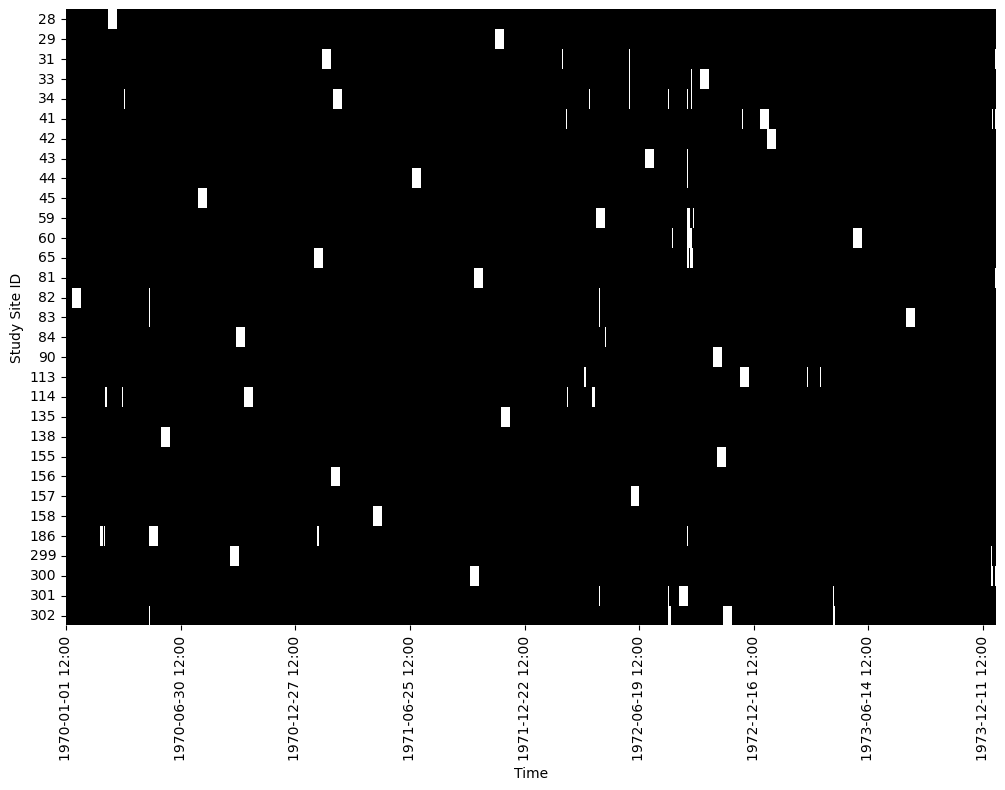

In [312]:
# Creating a boolean DataFrame where True indicates non-missing data
non_missing_data = ~df.isna()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

# Formatting the time axis labels
date_format = DateFormatter('%Y-%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Time')
plt.ylabel('Study Site ID')


In [313]:
df

,28,29,31,33,34,41,42,43,44,45,...,138,155,156,157,158,186,299,300,301,302
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,4.197639,6.454596,9.529580,3.631400,3.334823,8.434240,7.626667,4.356500,4.877646,5.972792,...,2.487500,1.958292,5.307083,2.347458,1.012500,6.877900,2.988958,8.874461,2.352760,1.291667
2020-06-02,3.581806,5.852821,7.343972,3.261156,3.065167,9.896635,9.364653,4.248385,4.498625,6.275287,...,2.970833,2.291698,4.367802,2.809573,1.245833,5.413583,3.170903,5.931818,2.461698,1.270833
2020-06-03,4.045000,4.881542,6.933732,3.388055,2.934104,9.446708,7.714718,4.244375,4.436823,5.148438,...,3.091304,2.497295,4.391292,3.126968,1.400000,5.097958,3.833333,4.948095,3.133750,1.895833
2020-06-04,5.172639,5.589927,7.458958,3.351885,2.979823,9.173892,6.280909,4.172688,4.267812,4.903719,...,2.566667,2.490406,4.290031,3.332010,1.479167,6.008333,3.836806,4.457490,3.022958,1.729167
2020-06-05,5.240278,6.161083,7.451042,3.551417,3.040417,8.963098,6.332958,4.390354,4.542833,4.901135,...,2.636364,2.742906,4.728750,3.475552,1.562500,6.805167,5.238611,5.648625,3.456313,1.908333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,8.793194,10.010917,10.691952,7.108116,5.979292,11.173289,10.583883,6.222875,6.770813,8.610284,...,5.091667,4.830281,7.754177,5.506083,5.237500,7.194604,8.790305,8.918588,7.392490,4.279167
2024-05-28,10.259931,10.436146,10.275042,9.305885,7.047649,10.986306,10.485278,6.478833,7.280875,8.981417,...,6.358333,6.233146,8.267771,7.462948,5.695833,7.258167,8.976319,8.788448,8.567979,4.837500
2024-05-29,10.079167,10.424000,9.701333,8.835250,8.168365,10.996816,9.958056,6.506302,7.204719,8.562240,...,6.500000,7.533646,8.736708,7.972073,7.404167,7.832729,9.070000,8.887744,8.868734,5.391667


In [314]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1)
rgr = RandomForestRegressor(n_jobs=-1, n_estimators=200)

imputer = MissForest(clf, rgr, verbose=1,max_iter=10)

df_imputed = imputer.fit_transform(df)


%|                                                                                            | 0/10 [00:00<?, ?it/s]
%|████████▍                                                                           | 1/10 [00:34<05:07, 34.13s/it]
%|████████████████▊                                                                   | 2/10 [01:08<04:31, 33.99s/it]
%|█████████████████████████▏                                                          | 3/10 [01:41<03:56, 33.79s/it]
%|█████████████████████████████████▌                                                  | 4/10 [02:15<03:23, 33.87s/it]
%|██████████████████████████████████████████                                          | 5/10 [02:49<02:49, 33.86s/it]
%|██████████████████████████████████████████████████▍                                 | 6/10 [03:24<02:16, 34.13s/it]
%|██████████████████████████████████████████████████████████▊                         | 7/10 [03:56<01:41, 33.73s/it]
%|█████████████████████████████████████████████████████

In [265]:
df_imputed.columns

Index(['28', '29', '45', '90', '135', '138', '155', '42', '157', '158', '156',
       '84', '81', '82', '83', '33', '301', '44', '31', '299', '43', '41',
       '300', '34', '59', '65', '113', '114', '302', '186', '60'],
      dtype='object')

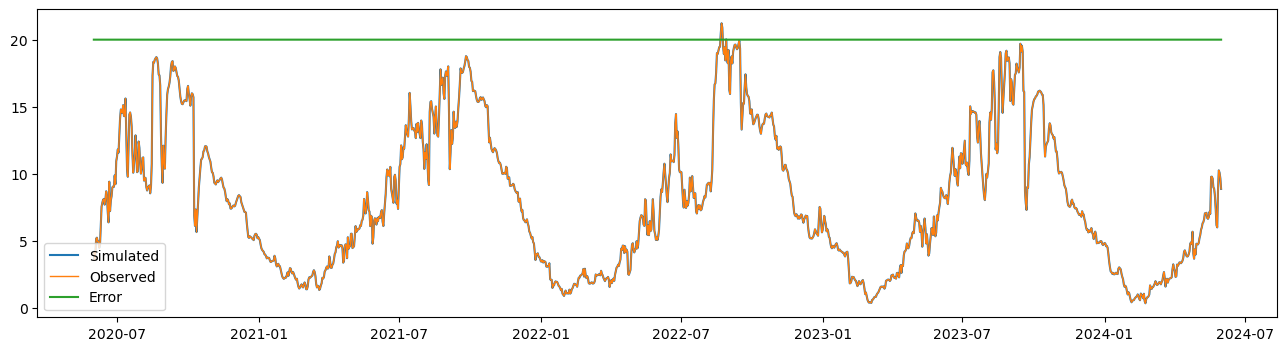

In [310]:
station_id = '28'

plt.subplots(figsize=(16,4))

plt.plot(df_imputed[station_id], label='Simulated')
plt.plot(df_selected[station_id], label='Observed', linewidth=1)


plt.plot(abs(df_selected[station_id] - df_imputed[station_id])+20, label='Error')

#plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-07-31'))
plt.legend()

## Remove single observations

In [268]:
df = df_selected.copy()

# remove randomly selected n days as missing for each column
n = 14
for col in df.columns:
    # Randomly sample unique dates
    random_dates = np.random.choice(df.index, size=n, replace=False)
    
    # Set the values to NaN for those dates
    df.loc[random_dates, col] = np.nan
    

Text(120.72222222222221, 0.5, 'Study Site ID')

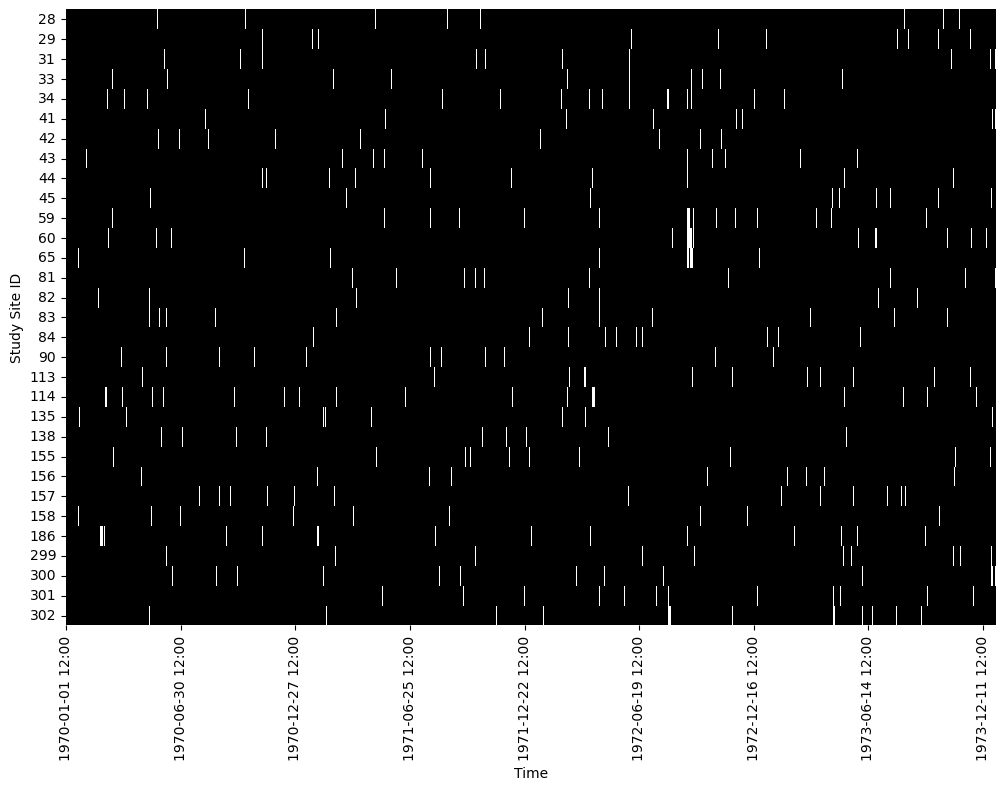

In [269]:
# Creating a boolean DataFrame where True indicates non-missing data
non_missing_data = ~df.isna()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

# Formatting the time axis labels
date_format = DateFormatter('%Y-%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Time')
plt.ylabel('Study Site ID')

In [284]:
clf = RandomForestClassifier(n_jobs=-1)
rgr = RandomForestRegressor(n_jobs=-1, n_estimators=200)

imputer = MissForest(clf, rgr, verbose=1,max_iter=10)

df_imputed = imputer.fit_transform(df)


  0%|                                                                                            | 0/10 [00:23<?, ?it/s]


KeyboardInterrupt: 

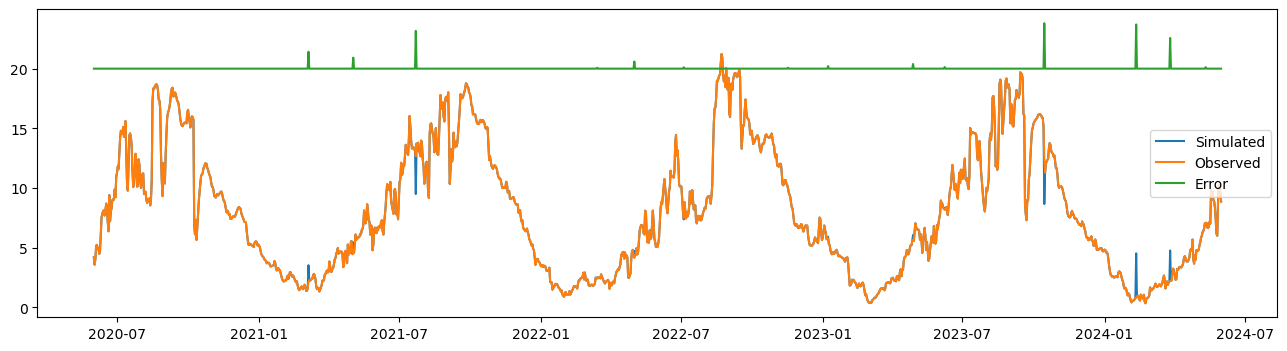

In [254]:
station_id = '28'

plt.subplots(figsize=(16,4))

plt.plot(df_imputed[station_id], label='Simulated')
plt.plot(df_selected[station_id], label='Observed')

plt.plot(abs(df_selected[station_id] - df_imputed[station_id])+20, label='Error')

plt.legend()

In [133]:
from missforest import MissForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1)
rgr = RandomForestRegressor(n_jobs=-1)

imputer = MissForest(clf, rgr, max_iter=20)
#imputer = MissForest(max_iter=10)

# Impute away
df_imputed = imputer.fit_transform(df_selected)

/home/jmunroe/miniforge3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "

%|                                                                                            | 0/20 [00:00<?, ?it/s]
%|████▏                                                                               | 1/20 [01:37<30:56, 97.72s/it]
%|████████▍                                                                           | 2/20 [03:17<29:36, 98.72s/it]
%|████████████▍                                                                      | 3/20 [05:00<28:34, 100.88s/it]
%|████████████████▌                                                                  | 4/20 [06:41<26:55, 100.96s/it]
%|████████████████████▊                                                              | 5/20 [08:23<25:17, 101.20s/it]
%|█

In [134]:
df_imputed

,28,29,155,90,135,138,42,45,158,84,...,74,185,80,184,154,278,276,277,275,52
date,,,,,,,,,,,,,,,,,,,,,
2020-06-02,3.581806,5.852821,2.291698,4.233889,5.029861,2.970833,9.364653,6.275287,1.245833,2.612292,...,2.176407,4.641528,3.966247,6.955057,4.073611,7.459015,7.852623,7.535480,7.743608,7.955665
2020-06-03,4.045000,4.881542,2.497295,4.703194,4.995833,3.091304,7.714718,5.148438,1.400000,2.349927,...,1.369798,4.678611,3.348568,6.905845,4.091389,7.439585,7.847765,7.528091,7.732519,8.176140
2020-06-04,5.172639,5.589927,2.490406,3.844444,4.654444,2.566667,6.280909,4.903719,1.479167,2.754479,...,1.325323,5.686389,3.182822,6.885267,4.103472,7.436081,7.856931,7.531108,7.732666,8.163726
2020-06-05,5.240278,6.161083,2.742906,4.970556,4.856806,2.636364,6.332958,4.901135,1.562500,2.771833,...,1.374375,6.429861,3.898914,6.985414,4.320139,7.447885,7.849353,7.543705,7.735064,6.553039
2020-06-06,4.950417,6.061958,2.845198,4.861528,4.495694,2.445833,5.719161,4.804135,1.637500,2.357740,...,1.393344,5.845833,4.179303,7.080864,4.454306,7.438878,7.852208,7.528214,7.734257,6.009061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,8.793194,10.010917,4.830281,7.520423,7.313958,5.091667,10.583883,8.610284,5.237500,5.832484,...,5.632422,6.324722,7.718794,10.063603,6.844653,11.186219,12.134242,11.420875,11.940278,9.236631
2024-05-28,10.259931,10.436146,6.233146,5.061250,8.174444,6.358333,10.485278,8.981417,5.695833,7.913833,...,5.643747,6.720417,9.278872,9.443162,8.182222,11.405574,12.392221,11.901250,12.200982,9.108234
2024-05-29,10.079167,10.424000,7.533646,5.552639,8.192222,6.500000,9.958056,8.562240,7.404167,4.584250,...,5.631201,7.525000,6.195594,8.460407,8.174861,10.848010,11.963774,11.176854,11.646182,9.120036


In [135]:
df_imputed.columns

Index(['28', '29', '155', '90', '135', '138', '42', '45', '158', '84', '81',
       '156', '157', '83', '82', '44', '33', '301', '43', '31', '299', '300',
       '41', '59', '34', '65', '113', '302', '186', '114', '60', '56', '62',
       '243', '242', '27', '58', '63', '279', '35', '280', '71', '72', '73',
       '177', '176', '94', '93', '91', '92', '281', '53', '51', '178', '282',
       '57', '115', '112', '174', '172', '175', '128', '130', '39', '38', '36',
       '61', '64', '37', '40', '127', '74', '185', '80', '184', '154', '278',
       '276', '277', '275', '52'],
      dtype='object')

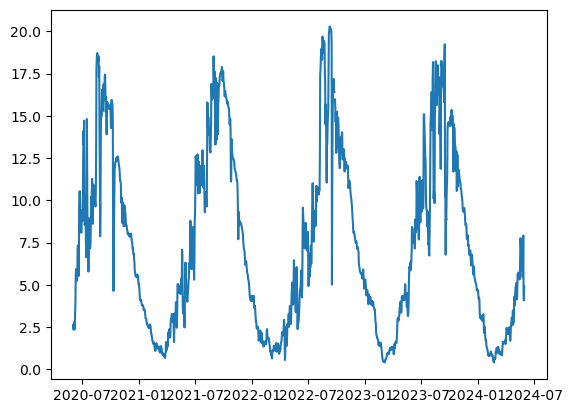

In [142]:
station_id = '84'

#plt.plot(df_imputed[station_id])
plt.plot(df_selected[station_id])
#plt.axhline(df_selected[station_id].median())

In [118]:
df_imputed.columns

Index(['28', '29', '155', '90', '135', '138', '42', '45', '158', '84', '81',
       '156', '157', '83', '82', '44', '33', '301', '43', '31', '299', '300',
       '41', '59', '34', '65', '113', '302', '186', '114', '60', '56', '62',
       '243', '242', '27', '58', '63', '279', '35', '280', '71', '72', '73',
       '177', '176', '94', '93', '91', '92', '281', '53', '51', '178', '282',
       '57', '115', '112', '174', '172', '175', '128', '130', '39', '38', '36',
       '61', '64', '37', '40', '127', '74', '185', '80', '184', '154', '278',
       '276', '277', '275', '52'],
      dtype='object')

In [119]:
selected_sites

Index(['27', '28', '29', '31', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '51', '52', '53', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '71', '72', '73', '74', '80', '81',
       '82', '83', '84', '90', '91', '92', '93', '94', '112', '113', '114',
       '115', '127', '128', '130', '135', '138', '154', '155', '156', '157',
       '158', '172', '174', '175', '176', '177', '178', '184', '185', '186',
       '242', '243', '275', '276', '277', '278', '279', '280', '281', '282',
       '299', '300', '301', '302'],
      dtype='object')

,Unnamed: 0,waterbody,station,latitude,longitude,deployment_range,sensor_type,sensor_serial_number,sensor_depth_at_low_tide_m
1594,1594,Liverpool Bay,Mersey Point,44.026097,-64.665763,2022-Aug-10 to 2023-Aug-24,vr2ar,547093,15.0
1598,1598,Liverpool Bay,Mersey Point,44.026110,-64.665740,2020-Jun-25 to 2021-Aug-13,vr2ar,547112,15.0
1602,1602,Liverpool Bay,Mersey Point,44.026114,-64.665773,2023-Aug-24 to 2024-Jul-22,vr2ar,548555,15.0
1606,1606,Liverpool Bay,Mersey Point,44.026146,-64.665750,2021-Aug-13 to 2022-Aug-10,vr2ar,548044,15.0


Text(0, 0.5, 'temperature_degree_c')

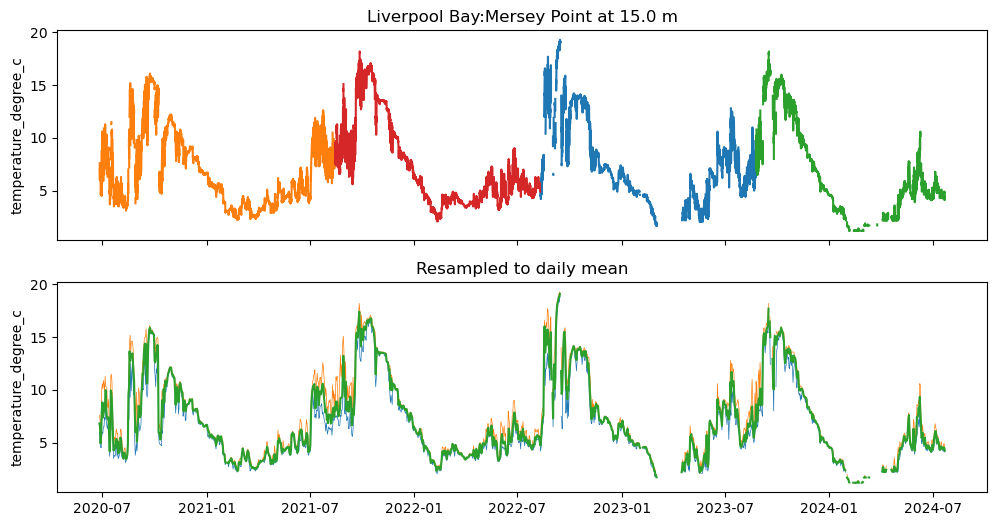

In [202]:
variable = 'temperature_degree_c'
#variable = 'dissolved_oxygen_percent_saturation'
qcflag = 'qc_flag_' + variable

study_site = study_sites.iloc[282]

subset = metadata[ (metadata['waterbody'] == study_site.waterbody) &  (metadata['station'] == study_site.station) & (metadata['sensor_depth_at_low_tide_m'] == study_site.sensor_depth_at_low_tide_m)]
display(subset)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)

series_segments = []
for segment_id in subset.index:
     
    series_filename = os.path.join(variable, f'{segment_id}_{variable}.csv')
   
    series = pd.read_csv(series_filename, index_col='timestamp_utc', parse_dates=True, date_format="%m/%d/%Y %I:%M:%S %p")
    series.sort_index(inplace=True)

    # blank out observations that do not pass QC
    series[series[qcflag] != 'Pass'] = np.nan
    series = series.drop(columns=[qcflag])
    
    ax[0].plot(series.index, series[variable])
    
    ax[0].set_ylabel(variable)
    ax[0].set_title(f'{study_site.waterbody}:{study_site.station} at {study_site.sensor_depth_at_low_tide_m} m')


    if series.count()[variable] > 0:
        series_segments.append(series)

series_df = pd.concat(series_segments)
series_df.sort_index(inplace=True)
daily_series_df = series_df.resample('D').max()

ax[1].set_title('Resampled to daily mean')
daily_series_df = series_df.resample('D').min()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='min', linewidth=0.5)
daily_series_df = series_df.resample('D').max()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='max', linewidth=0.5)
daily_series_df = series_df.resample('D').mean()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='mean')

ax[1].set_ylabel(variable)



In [230]:
X

,3,4,5,27,28,29,31,32,33,34,...,279,280,281,282,299,300,301,302,310,311
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.133417,0.156708,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.254875,0.262917,NaN,NaN,NaN
2018-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.433542,0.455417,NaN,NaN,NaN
2018-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.399000,0.426667,NaN,NaN,NaN
2018-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.282542,0.313708,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03,NaN,NaN,NaN,NaN,NaN,NaN,10.627708,NaN,10.239000,9.762271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-04,NaN,NaN,NaN,NaN,NaN,NaN,10.126417,NaN,9.979990,9.971750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,10.216333,NaN,10.114219,10.068219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-06,NaN,NaN,NaN,NaN,NaN,NaN,10.556427,NaN,10.400823,10.293156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
